In [2]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, TensorDataset, random_split


In [3]:
import sys

paths = [
    "/kaggle/input/topological/pytorch/default/1/topological-purification/src/model",
    "/kaggle/input/topological/pytorch/default/1/topological-purification/src",
]

for path in paths:
    sys.path.append(path)

In [4]:
os.chdir("../")
print(os.getcwd())
print(os.listdir())
os.makedirs("my_folder", exist_ok=True)

/kaggle
['lib', 'input', 'working']


In [5]:
from DAE_model import DenoisingAutoEncoder as DAE
from model import CNNClassifier as clf

In [16]:
os.chdir("/kaggle/working")
print(os.getcwd())

/kaggle/working


## Wandb

In [ ]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("add")

wandb.login(key=wandb_api_key)

# Worker

In [33]:
import sys
import matplotlib
matplotlib.use('Agg') 
from scipy.stats import entropy
from numpy.linalg import norm
from matplotlib.ticker import FuncFormatter
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pylab
import os
from utils import prepare_data
import utils as utils
import matplotlib.pyplot as plt

class AEDetector:
    def __init__(self, model_class, model_path, p=1, device=None,model_kwargs=None):
        """
        Error-based detector.

        model_class: The class of the AE model (e.g., DenoisingAutoEncoder).
        model_path: Path to the model's saved state_dict (.pth).
        p: Power for error norm (e.g., 1 = L1, 2 = L2).
        device: torch.device object or string ("cuda" / "cpu").
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model_class(**(model_kwargs or {})).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        self.p = p
        
    def mark(self, X):
        """
        X: A PyTorch tensor of shape [N, C, H, W] on CPU or GPU.
        Returns: 1D numpy array of anomaly scores (reconstruction errors).
        """
        self.model.eval()

        with torch.no_grad():
            if X.ndim == 4 and X.shape[1:] == torch.Size([28, 28, 1]):
                
                X = X.permute(0, 3, 1, 2)

            X = X.to(self.device)
            recon = self.model(X)
            diff = torch.abs(X - recon)  # Absolute error
            score = torch.mean(torch.pow(diff, self.p), dim=[1, 2, 3])  # Per-sample score
            return score.cpu().numpy()  # Convert to NumPy for compatibility

    def print(self):
        return "AEDetector:" + os.path.basename(self.path)


class IdReformer:
    def __init__(self, path="IdentityFunction"):
        """
        Identity reformer. Returns input unchanged.
        """
        self.path = path
        self.heal = lambda X: X  # No transformation

    def print(self):
        return "IdReformer:" + self.path


class SimpleReformer:
    def __init__(self, model_class, model_path, device=None, model_kwargs=None):
        """
        Autoencoder-based reformer. Applies reconstruction (healing).

        model_class: Class definition of the autoencoder.
        path: Path to the saved model (.pth).
        device: torch.device or str ("cuda" or "cpu").
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model_class(**(model_kwargs or {})).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        self.image_shape = self.model.image_shape

    def heal(self, X):
        """
        X: Tensor [N, C, H, W] (should be on same device as model)
        Returns: Reconstructed input clipped between 0 and 1 (as Torch Tensor)
        """
        self.model.eval()
        with torch.no_grad():
            X = X.to(self.device)
            if X.ndim == 3:  # Single image
                if X.shape[-1] == 1:  # HWC format
                    X = X.permute(2, 0, 1).unsqueeze(0)  # Convert to NCHW
                else:  # CHW format
                    X = X.unsqueeze(0)  # Add batch dimension
            elif X.ndim == 4:  # Batch of images
                if X.shape[-1] == 1:  # NHWC format
                    X = X.permute(0, 3, 1, 2)  # Convert to NCHW
        
        # Ensure proper normalization (autoencoders are sensitive to input range)
            if X.max() > 1.0:
                X = X / 255.0
            print(f"Input range: [{X.min():.6f}, {X.max():.6f}]")
            print(f"Input mean: {X.mean():.6f}")
            print(f"Input std: {X.std():.6f}")
        
        # Check intermediate representations
            if hasattr(self.model, 'encoder'):
                latent = self.model.encoder(X)
                print(f"Latent range: [{latent.min():.6f}, {latent.max():.6f}]")
                print(f"Latent mean: {latent.mean():.6f}")
                print(f"Latent near-zero count: {(torch.abs(latent) < 1e-6).sum().item()}/{latent.numel()}")
            recon = self.model(X)
            recon = torch.clamp(recon, 0.0, 1.0)
            print(f"Output range: [{recon.min():.6f}, {recon.max():.6f}]")
            print(f"Output mean: {recon.mean():.6f}")
            return recon

    def print(self):
        return "SimpleReformer:" + os.path.basename(self.path)


def JSD(P, Q):
    """
    Jensen-Shannon Divergence between two 1D arrays (P, Q).
    P, Q: Numpy arrays representing discrete distributions.
    """
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))


class DBDetector:
    def __init__(self, reconstructor, prober, classifier, option="jsd", T=1):
        """
        Divergence-Based Detector using PyTorch.

        reconstructor: One reformer (e.g., SimpleReformer instance).
        prober: Another reformer (same type).
        classifier: Classifier object with classify() method.
        option: Distance measure to use, default is 'jsd'.
        T: Temperature for softmax (scaling logits).
        """
        self.prober = prober
        self.reconstructor = reconstructor
        self.classifier = classifier
        self.option = option
        self.T = T

    def mark(self, X):
        if self.option == "jsd":
            return self.mark_jsd(X)
        else:
            raise NotImplementedError(f"Only 'jsd' is implemented, got {self.option}")

    def mark_jsd(self, X):
        """
        Returns JSD divergence between classifier outputs on
        probed and reconstructed samples.
        
        X: Input tensor [N, C, H, W] (torch.Tensor)
        """
        Xp = self.prober.heal(X)
        Xr = self.reconstructor.heal(X)

        Pp = self.classifier.classify(Xp, option="prob", T=self.T)  # numpy array [N, num_classes]
        Pr = self.classifier.classify(Xr, option="prob", T=self.T)

        marks = [JSD(Pp[i], Pr[i]) for i in range(len(Pr))]
        return np.array(marks)

    def print(self):
        return "Divergence-Based Detector"



class Classifier:
    def __init__(self, model_class, classifier_path, device=None, model_kwargs=None):
        """
        PyTorch classifier wrapper. Assumes the model outputs raw logits.

        model_class: A callable (e.g., a class or lambda) that returns the classifier architecture.
        classifier_path: Path to saved model weights (.pth).
        device: torch.device or string ("cuda"/"cpu"). Auto-detected if not provided.
        model_kwargs: dict of kwargs for model_class constructor
        """
        self.path = classifier_path
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = model_class(**(model_kwargs or {})).to(self.device)
        self.model.load_state_dict(torch.load(classifier_path, map_location=self.device))
        self.model.eval()

    def classify(self, X, option="logit", T=1):
        """
        Classify input.

        X: Torch tensor [N, C, H, W]
        option: "logit" to return raw logits, "prob" to return softmax probs.
        T: Temperature (used only with option="prob")
        Returns: NumPy array
        """
        if X.ndim == 4 and X.shape[1:] == torch.Size([28, 28, 1]):
            X = X.permute(0, 3, 1, 2)
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.from_numpy(X).float()

            X = X.to(self.device)
            logits = self.model(X)

            if option == "logit":
                return logits.cpu().numpy()

            elif option == "prob":
                probs = F.softmax(logits / T, dim=1)
                return probs.cpu().numpy()

            else:
                raise ValueError(f"Invalid option: {option}. Use 'logit' or 'prob'.")

    def print(self):
        return "Classifier:" + os.path.basename(self.path)


class Operator:
    def __init__(self, data, classifier, det_dict, reformer):
        """
        Operator that wraps the data, classifier, detector(s), and reformer logic.

        data: MNIST object with .train_loader, .validation_loader, .test_loader
        classifier: Classifier object (must have .classify(X) method)
        det_dict: Dictionary of detectors, each with .mark(X)
        reformer: Reformer object (must have .heal(X))
        """
        self.data = data
        self.classifier = classifier
        self.det_dict = det_dict
        self.reformer = reformer

        test_imgs = torch.stack([img for img, _ in data.test_data])
        test_labels = torch.tensor([label for _, label in data.test_data])
        self.normal = self.operate(AttackData(test_imgs, test_labels, "Normal"))

    def get_thrs(self, drop_rate):
        """
        Calculates thresholds for filtering from validation set.
        drop_rate: Dict mapping detector names to float drop rates.
        """
        thrs = {}
        val_imgs = torch.stack([img for img, _ in self.data.validation_data])
        for name, detector in self.det_dict.items():
            num = int(len(val_imgs) * drop_rate[name])
            marks = detector.mark(val_imgs)
            sorted_marks = np.sort(marks)
            thrs[name] = sorted_marks[-num]
        return thrs

    def operate(self, untrusted_obj):
        """
        Classifies original and reformed inputs using the classifier.
        Returns: Array of (original_correct, reformed_correct) pairs.
        """
        X = untrusted_obj.data
        Y_true = untrusted_obj.labels

        with torch.no_grad():
            X_prime = self.reformer.heal(X)
            Y_pred = torch.tensor(np.argmax(self.classifier.classify(X), axis=1))
            Y_judgement = (Y_pred == Y_true[:len(X_prime)])

            Yp_pred = torch.tensor(np.argmax(self.classifier.classify(X_prime), axis=1))
            Yp_judgement = (Yp_pred == Y_true[:len(X_prime)])

        return np.array(list(zip(Y_judgement.cpu().numpy(), Yp_judgement.cpu().numpy())))

    def filter(self, X, thrs):
        """
        Filters inputs using detector thresholds.
        Returns indices that passed all filters.
        """
        all_pass = np.arange(X.shape[0])
        collector = {}

        for name, detector in self.det_dict.items():
            marks = detector.mark(X)
            idx_pass = np.argwhere(marks < thrs[name]).flatten()
            collector[name] = len(idx_pass)
            all_pass = np.intersect1d(all_pass, idx_pass)

        return all_pass, collector

    def print(self):
        components = [self.reformer, self.classifier]
        return " ".join(obj.print() for obj in components)

class AttackData:
    def __init__(self, examples, labels, name="",directory="/kaggle/input/required8"):
        """
        Wrapper for input data (normal or adversarial).
        
        examples: Tensor or path to saved object.
        labels: Tensor or numpy array of ground truth labels.
        name: Identifier string.
        """
        if isinstance(examples, str):
            self.data = utils.load_obj(examples,directory)  # Should return a torch tensor or NumPy array
            if isinstance(self.data, np.ndarray):
                self.data = torch.tensor(self.data, dtype=torch.float32)
        else:
            self.data = examples if torch.is_tensor(examples) else torch.tensor(examples, dtype=torch.float32)

        self.labels = labels if torch.is_tensor(labels) else torch.tensor(labels, dtype=torch.long)
        self.name = name

    def print(self):
        return "Attack:" + self.name


class Evaluator:
    def __init__(self, operator, untrusted_data, graph_dir="./graph"):
        """
        Evaluator for analyzing the defense strategy.

        operator: Operator object.
        untrusted_data: Adversarial or noisy test dataset wrapped in AttackData.
        graph_dir: Path to save graphs.
        """
        self.operator = operator
        self.untrusted_data = untrusted_data
        self.graph_dir = graph_dir
        self.data_package = operator.operate(untrusted_data)

    def bind_operator(self, operator):
        """
        Replace current operator and re-evaluate.
        """
        self.operator = operator
        self.data_package = operator.operate(self.untrusted_data)

    def load_data(self, data):
        """
        Replace current untrusted data and re-evaluate.
        """
        self.untrusted_data = data
        self.data_package = self.operator.operate(self.untrusted_data)

    def get_normal_acc(self, normal_all_pass):
        """
        Measure classification accuracy on clean data after filtering.

        Returns:
        - both_acc: Accuracy when both detector and reformer pass.
        - det_only_acc: Accuracy with just detector.
        - ref_only_acc: Accuracy with just reformer.
        - none_acc: Accuracy without any defense.
        """
        normal_tups = self.operator.normal
        num_normal = len(normal_tups)
        filtered_normal_tups = normal_tups[normal_all_pass]

        both_acc = sum(1 for _, XpC in filtered_normal_tups if XpC) / num_normal
        det_only_acc = sum(1 for XC, _ in filtered_normal_tups if XC) / num_normal
        ref_only_acc = sum(1 for _, XpC in normal_tups if XpC) / num_normal
        none_acc = sum(1 for XC, _ in normal_tups if XC) / num_normal

        return both_acc, det_only_acc, ref_only_acc, none_acc

    def get_attack_acc(self, attack_pass):
        """
        Measure classification accuracy on adversarial data.

        Returns same metrics as get_normal_acc.
        """
        attack_tups = self.data_package
        num_untrusted = len(attack_tups)
        filtered_attack_tups = attack_tups[attack_pass]

        both_acc = 1 - sum(1 for _, XpC in filtered_attack_tups if not XpC) / num_untrusted
        det_only_acc = 1 - sum(1 for XC, _ in filtered_attack_tups if not XC) / num_untrusted
        ref_only_acc = sum(1 for _, XpC in attack_tups if XpC) / num_untrusted
        none_acc = sum(1 for XC, _ in attack_tups if XC) / num_untrusted

        return both_acc, det_only_acc, ref_only_acc, none_acc

    def plot_various_confidences(self, graph_name, drop_rate,
                                 idx_file="example_idx",
                                 confs=(0.0, 10.0, 20.0, 30.0, 40.0),
                                 get_attack_data_name=lambda c: f"example_fgsm_0.3",
                                 data_dir="/kaggle/working/generated_attacks",
                                 idx_file_dir="/kaggle/input/required8"):  # new parameter for index directory
    
        pylab.rcParams['figure.figsize'] = 6, 4
        fig = plt.figure()
    
        for conf in confs:
            attack_data_name = get_attack_data_name(conf)
            attack_data = utils.load_obj(attack_data_name, directory=data_dir)
            attack_idx = utils.load_obj(idx_file, directory=idx_file_dir)  # Load from different dir
            max_idx = len(attack_data) - 1
            attack_idx = attack_idx[attack_idx < len(self.untrusted_data.labels)]
            X_adv = attack_data[attack_idx]
            Y_true = self.untrusted_data.labels[attack_idx]
            attack_dataset = AttackData(X_adv, Y_true, name=f"Conf={conf}")
    
            self.load_data(attack_dataset)
            print(f"Confidence {conf} - # attack samples: {len(attack_dataset.data)}")
            thrs = {
                "I": 0.81,
                "II": 0.85
            }
            attack_pass, _ = self.operator.filter(attack_dataset.data, thrs)
            print(f"Passing samples: {len(attack_pass)} out of {len(attack_dataset.data)}")
            accs = self.get_attack_acc(attack_pass)
    
            plt.plot(conf, accs[0], 'bo')
            plt.plot(conf, accs[1], 'go')
            plt.plot(conf, accs[2], 'ro')
            plt.plot(conf, accs[3], 'ko')
    
        plt.xlabel("Attack Confidence")
        plt.ylabel("Classification Accuracy")
        plt.title("Defense Performance vs. Attack Confidence")
        plt.legend(["both", "det_only", "ref_only", "none"])
        plt.grid(True)
        graph_path = os.path.join(self.graph_dir, graph_name + ".png")
        os.makedirs(self.graph_dir, exist_ok=True)
        plt.savefig(graph_path)
        plt.close(fig)

In [58]:

from dataloader import MNIST
from utils import prepare_data, load_obj
from DAE_model import DenoisingAutoEncoder
from model import CNNClassifier
# from worker import Operator, AttackData, Evaluator, AEDetector, SimpleReformer, IdReformer, Classifier

# ---- Load models ----
detector_I = AEDetector(DenoisingAutoEncoder, "/kaggle/input/topological/pytorch/default/1/topological-purification/data/MNIST_I.pth", p=2, model_kwargs={'image_shape': (1, 28, 28), 'structure': [3,"average",3], 'v_noise': 0.1, 'activation': 'relu', 'model_dir': './defensive_models/', 'reg_strength': 0.0})
detector_II = AEDetector(DenoisingAutoEncoder, "/kaggle/input/topological/pytorch/default/1/topological-purification/data/MNIST_II.pth", p=1, model_kwargs={'image_shape': (1, 28, 28), 'structure': [3], 'v_noise': 0.1, 'activation': 'relu', 'model_dir': './defensive_models/', 'reg_strength': 0.0})
reformer = SimpleReformer(DenoisingAutoEncoder, "/kaggle/input/topological/pytorch/default/1/topological-purification/data/MNIST_I.pth", model_kwargs={'image_shape': (1, 28, 28), 'structure': [3,"average",3], 'v_noise': 0.1, 'activation': 'relu', 'model_dir' : './defensive_models/', 'reg_strength': 0.0})
id_reformer = IdReformer()
classifier = Classifier(CNNClassifier, "/kaggle/input/topological/pytorch/default/1/topological-purification/logs/example_classifier.pth",model_kwargs={'params' : [32,32,64,64,200,200]})

# ---- Compose detector dictionary ----
detector_dict = {
    "I": detector_I,
    "II": detector_II
}

# ---- Load MNIST data ----
dataset = MNIST()
operator = Operator(dataset, classifier, detector_dict, reformer)




Input range: [-1.000000, 1.000000]
Input mean: -0.734971
Input std: 0.620961
Latent range: [-21.035671, 1.351443]
Latent mean: -0.987502
Latent near-zero count: 0/5880000
Output range: [0.000000, 1.000000]
Output mean: 0.253179


## FGSM attacks

In [42]:
import torch

# FGSM attack function
def fgsm_attack(model, images, labels, epsilon=0.3):
    images = images.clone().detach().to(model.device).requires_grad_(True)
    labels = labels.to(model.device)

    model.model.eval()  # Ensure classifier model eval mode
    outputs = model.model(images)
    loss = torch.nn.functional.cross_entropy(outputs, labels)
    model.model.zero_grad()
    loss.backward()

    adv_images = images + epsilon * images.grad.sign()
    adv_images = torch.clamp(adv_images, 0, 1)  # MNIST images are in [0,1]
    return adv_images.detach().cpu()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.model.to(device)

# Generate adversarial examples on full test set
adv_images_list = []
adv_labels_list = []

for imgs, labels in dataset.test_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    adv_imgs = fgsm_attack(classifier, imgs, labels, epsilon=0.3)
    adv_images_list.append(adv_imgs)
    adv_labels_list.append(labels.cpu())

adv_images = torch.cat(adv_images_list, dim=0)
adv_labels = torch.cat(adv_labels_list, dim=0)

# Wrap in AttackData
test_attack = AttackData(adv_images, adv_labels, name="FGSM ε=0.3")



In [ ]:
# Evaluate defense
evaluator = Evaluator(operator, test_attack)
evaluator.plot_various_confidences(
    graph_name="defense_fgsm_full_test",
    drop_rate={"I": 0.1, "II": 0.1},
    confs=(0.3,),  # just this epsilon
    get_attack_data_name=lambda conf: "FGSM_full_test"  # dummy name
)

In [44]:
import pickle
import os

save_path = "/kaggle/working/generated_fgsm"
os.makedirs(save_path, exist_ok=True)

# Save images
with open(os.path.join(save_path, "example_fgsm_0.3.pkl"), "wb") as f:
    pickle.dump(adv_images.numpy(), f)

# Save labels
with open(os.path.join(save_path, "example_fgsm_labels.pkl"), "wb") as f:
    pickle.dump(adv_labels.numpy(), f)

In [43]:
# Use thresholds based on your detector behavior (tune as needed)
thresholds = {"I": 0.85, "II": 0.85}

# Filter adversarial data with detectors
attack_pass, _ = operator.filter(test_attack.data, thresholds)

# Get accuracy metrics
both_acc, det_only_acc, ref_only_acc, none_acc = evaluator.get_attack_acc(attack_pass)

print(f"Both detector+reformer accuracy: {both_acc:.4f}")
print(f"Detector-only accuracy: {det_only_acc:.4f}")
print(f"Reformer-only accuracy: {ref_only_acc:.4f}")
print(f"No defense accuracy: {none_acc:.4f}")

Both detector+reformer accuracy: 0.9347
Detector-only accuracy: 0.9890
Reformer-only accuracy: 0.0974
No defense accuracy: 0.7591


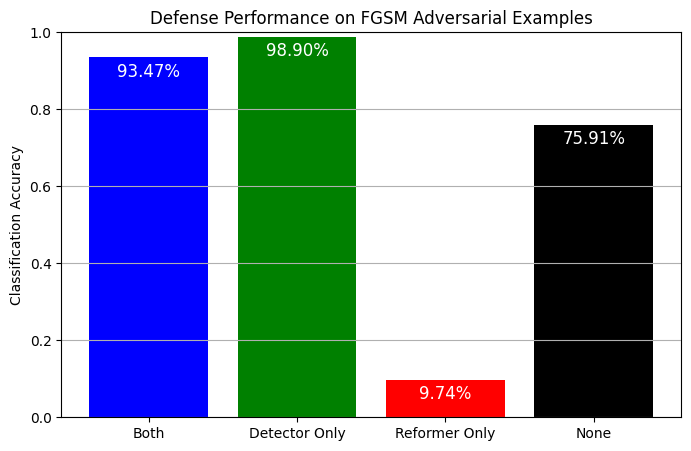

In [41]:
import matplotlib.pyplot as plt

def plot_defense_performance(evaluator, test_attack, operator, thresholds):
    attack_pass, _ = operator.filter(test_attack.data, thresholds)
    both_acc, det_only_acc, ref_only_acc, none_acc = evaluator.get_attack_acc(attack_pass)

    labels = ["Both", "Detector Only", "Reformer Only", "None"]
    accuracies = [both_acc, det_only_acc, ref_only_acc, none_acc]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, accuracies, color=['blue', 'green', 'red', 'black'])
    plt.ylim([0, 1])
    plt.ylabel("Classification Accuracy")
    plt.title("Defense Performance on FGSM Adversarial Examples")

    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
                 f"{acc:.2%}", ha='center', color='white', fontsize=12)

    plt.grid(axis='y')
    plt.show()

# Call once
thresholds = {"I": 0.85, "II": 0.85}
plot_defense_performance(evaluator, test_attack, operator, thresholds)

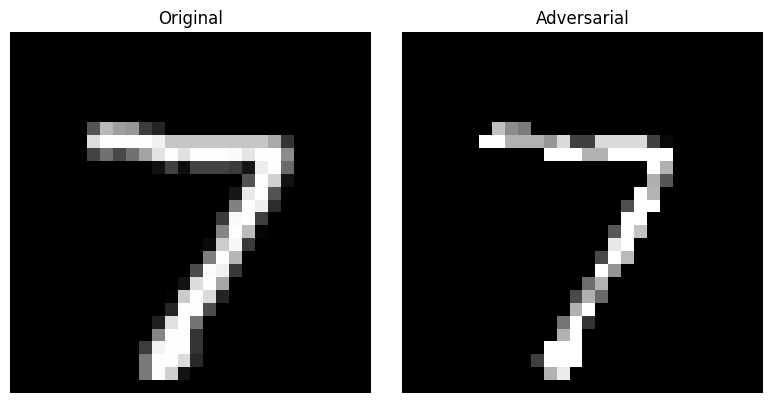

In [45]:
import matplotlib.pyplot as plt

# Pick a sample index to visualize
i = 0

orig = dataset.test_loader.dataset[i][0].squeeze().numpy()
adv  = adv_images[i].squeeze().numpy()

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(orig, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Adversarial")
plt.imshow(adv, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [46]:
epsilons = [0.05, 0.1, 0.2, 0.3]
results = []

for eps in epsilons:
    print(f"\nEvaluating FGSM with ε = {eps}")
    
    # Generate new adversarial examples
    adv_images_list = []
    adv_labels_list = []

    for imgs, labels in dataset.test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        adv_imgs = fgsm_attack(classifier, imgs, labels, epsilon=eps)
        adv_images_list.append(adv_imgs)
        adv_labels_list.append(labels.cpu())

    adv_images = torch.cat(adv_images_list, dim=0)
    adv_labels = torch.cat(adv_labels_list, dim=0)

    test_attack = AttackData(adv_images, adv_labels, name=f"FGSM ε={eps}")
    evaluator = Evaluator(operator, test_attack)

    attack_pass, _ = operator.filter(test_attack.data, thresholds)
    accs = evaluator.get_attack_acc(attack_pass)
    
    print(f"Both: {accs[0]:.4f}, Det Only: {accs[1]:.4f}, Ref Only: {accs[2]:.4f}, None: {accs[3]:.4f}")
    results.append((eps, accs))


Evaluating FGSM with ε = 0.05
Input range: [0.000000, 1.000000]
Input mean: 0.104557
Input std: 0.286380
Latent range: [-20.490953, 0.317475]
Latent mean: -3.978285
Latent near-zero count: 0/5880000
Output range: [0.996273, 1.000000]
Output mean: 0.999974
Both: 0.8896, Det Only: 0.9943, Ref Only: 0.0974, None: 0.8597

Evaluating FGSM with ε = 0.1
Input range: [0.000000, 1.000000]
Input mean: 0.103113
Input std: 0.282219
Latent range: [-20.435980, 0.317626]
Latent mean: -3.973110
Latent near-zero count: 1/5880000
Output range: [0.996698, 1.000000]
Output mean: 0.999974
Both: 0.8995, Det Only: 0.9931, Ref Only: 0.0974, None: 0.8462

Evaluating FGSM with ε = 0.2
Input range: [0.000000, 1.000000]
Input mean: 0.100232
Input std: 0.274797
Latent range: [-20.374380, 0.316815]
Latent mean: -3.962784
Latent near-zero count: 3/5880000
Output range: [0.996576, 1.000000]
Output mean: 0.999974
Both: 0.9183, Det Only: 0.9906, Ref Only: 0.0974, None: 0.8070

Evaluating FGSM with ε = 0.3
Input range:

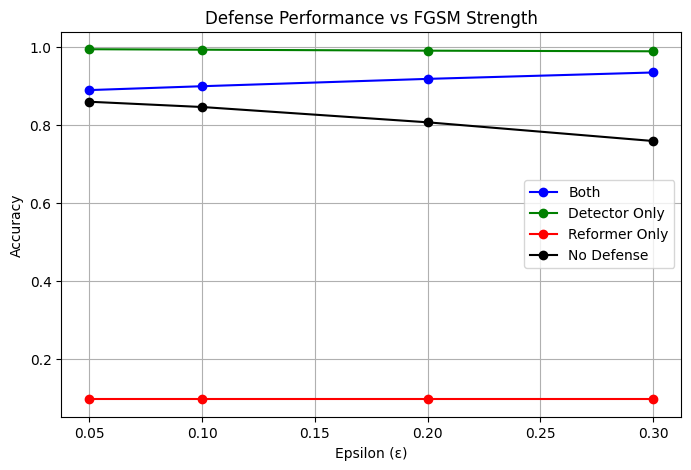

In [47]:
# Plot overall accuracy vs epsilon
import matplotlib.pyplot as plt

eps_vals = [r[0] for r in results]
both_accs = [r[1][0] for r in results]
det_accs  = [r[1][1] for r in results]
ref_accs  = [r[1][2] for r in results]
none_accs = [r[1][3] for r in results]

plt.figure(figsize=(8,5))
plt.plot(eps_vals, both_accs, 'bo-', label="Both")
plt.plot(eps_vals, det_accs,  'go-', label="Detector Only")
plt.plot(eps_vals, ref_accs,  'ro-', label="Reformer Only")
plt.plot(eps_vals, none_accs, 'ko-', label="No Defense")
plt.xlabel("Epsilon (ε)")
plt.ylabel("Accuracy")
plt.title("Defense Performance vs FGSM Strength")
plt.legend()
plt.grid(True)
plt.show()

## PGD

In [48]:
def pgd_attack(model, images, labels, epsilon=0.3, alpha=0.01, iters=40):

    model.model.eval()
    images = images.clone().detach().to(model.device)
    labels = labels.to(model.device)
    
    # Start from random perturbation within epsilon-ball
    adv_images = images + 2 * (torch.rand_like(images) - 0.5) * epsilon
    adv_images = torch.clamp(adv_images, 0, 1).detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model.model(adv_images)
        loss = F.cross_entropy(outputs, labels)
        adv_images.grad = None
        loss.backward()

        # Gradient step
        adv_images = adv_images + alpha * adv_images.grad.sign()
        
        # Project to ε-ball
        delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(images + delta, 0, 1).detach().requires_grad_(True)

    return adv_images.detach().cpu()

In [49]:
adv_images_list = []
adv_labels_list = []

for imgs, labels in dataset.test_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    adv_imgs = pgd_attack(classifier, imgs, labels, epsilon=0.3, alpha=0.01, iters=40)
    adv_images_list.append(adv_imgs)
    adv_labels_list.append(labels.cpu())

adv_images = torch.cat(adv_images_list)
adv_labels = torch.cat(adv_labels_list)

# Wrap into AttackData
test_attack = AttackData(adv_images, adv_labels, name="PGD ε=0.3")

In [50]:
evaluator = Evaluator(operator, test_attack)
thresholds = {"I": 0.85, "II": 0.85}
attack_pass, _ = operator.filter(test_attack.data, thresholds)

both_acc, det_only_acc, ref_only_acc, none_acc = evaluator.get_attack_acc(attack_pass)

print(f"PGD ε=0.3:")
print(f"  Both accuracy:       {both_acc:.4f}")
print(f"  Detector only:       {det_only_acc:.4f}")
print(f"  Reformer only:       {ref_only_acc:.4f}")
print(f"  No defense accuracy: {none_acc:.4f}")

Input range: [0.000000, 1.000000]
Input mean: 0.091125
Input std: 0.252396
Latent range: [-20.305576, 0.315669]
Latent mean: -3.930155
Latent near-zero count: 0/5880000
Output range: [0.996992, 1.000000]
Output mean: 0.999974
PGD ε=0.3:
  Both accuracy:       0.9504
  Detector only:       0.9595
  Reformer only:       0.0974
  No defense accuracy: 0.3241


Input range: [-1.000000, 1.000000]
Input mean: -0.815386
Input std: 0.517823
Latent range: [-17.571587, 1.241474]
Latent mean: -0.698076
Latent near-zero count: 0/588
Output range: [0.000000, 1.000000]
Output mean: 0.217271


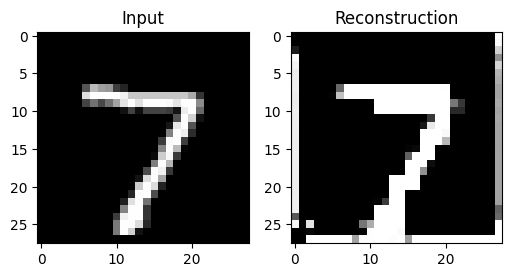

In [52]:
img = dataset.test_loader.dataset[0][0].unsqueeze(0).to(device)
recon = reformer.heal(img).squeeze().cpu().numpy()

plt.subplot(1,2,1); plt.imshow(img.squeeze().cpu(), cmap="gray"); plt.title("Input")
plt.subplot(1,2,2); plt.imshow(recon, cmap="gray"); plt.title("Reconstruction")
plt.show()